**Student Name**: Puneet

**Student Roll No**: 21f3002005

# Programming Assignment-2


Make a copy of the colab. Rename the colab as follows:

```
PA-2_<roll-number>.ipynb
```

We will be running your colab. It should produce the graphs/charts as explaind in the problem statements. Add comments wherever necessary. At the end of each problem configuration, enter your observations in the text cell. This should include your analysis of the learning curves obtaind.

### Libraries

Stick to `NumPy` and a library such as `matplotlib`, `seaborn` or `plotly` for rendering plots.

In [15]:
# import necessary libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Environment description

This exercise aims to familiarize you with two popular Temporal Difference Learning algorithms: **SARSA** and **Q-Learning**. You will solve several variants of the Grid World problem (a sample world is shown below in Figure 1).

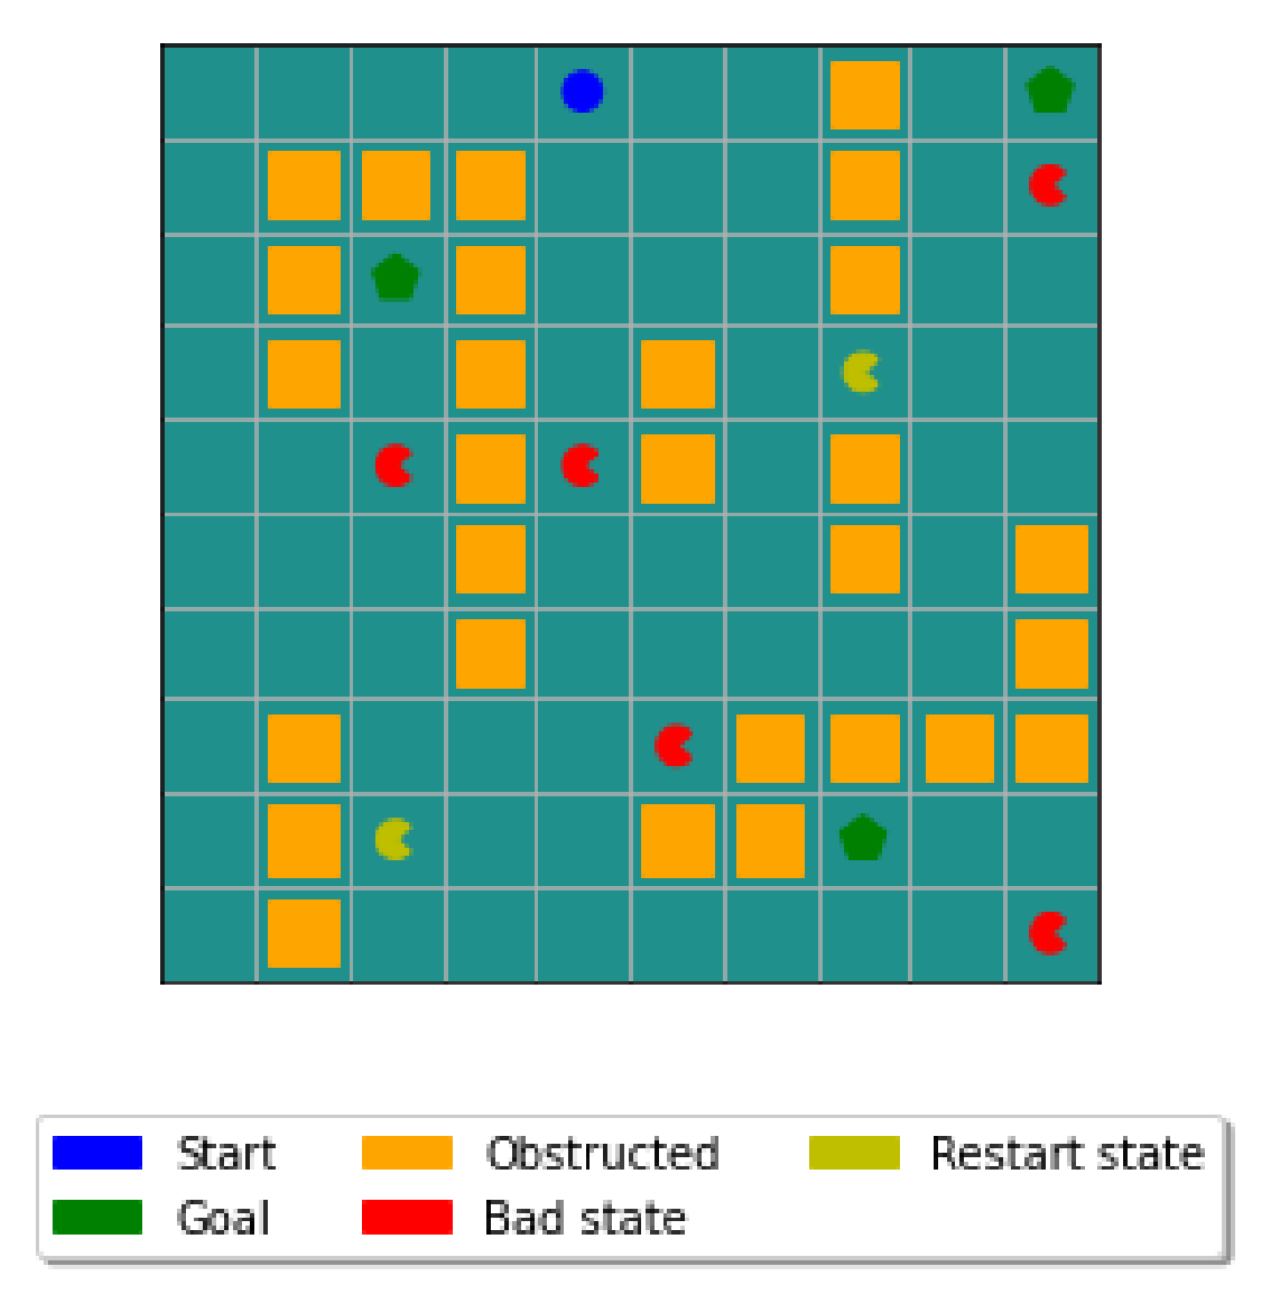

***Figure 1***

This is a grid world with 4 deterministic actions ('up', 'down', 'left', 'right'). The agent transitions to the next state determined by the direction of the action chosen with a probability of $p \in [0, 1]$. We also define a parameter called $b \in [0, 1]$ (Set $b=0.5$ for this assignment). Consider the direction of the action chosen as the agent's “North”. For example, if the action is 'left', it is the agent's North, and the agent's East would be the direction of the action 'up'. Figure 2 provides an illustration of the same. The agent transitions to the state West of the chosen action with probability $(1-p)\times b$, and to the East of the chosen action with probability $(1-p) \times (1-b)$.

 The environment may also have a wind blowing that can push the agent one **additional** cell to the right **after transitioning to the new state** with a probability of 0.4. An episode is terminated either when a goal is reached or when the timesteps exceed 100. Transitions that take you off the grid will not result in any change in state.

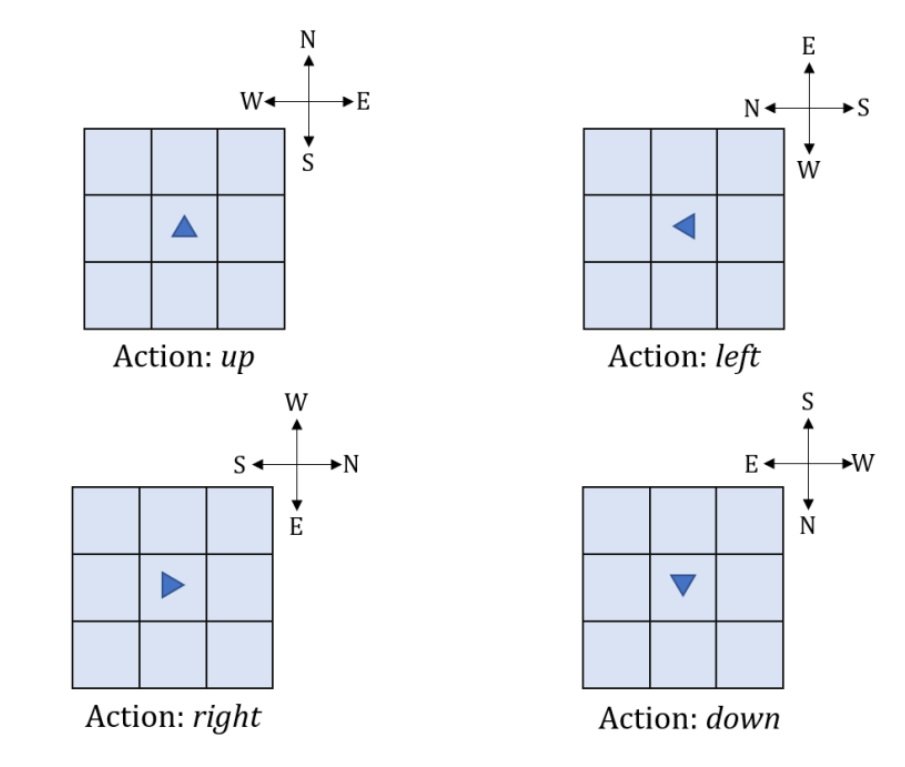

***Figure 2***

The dimensions of the grid are $10 \times 10$. The following types of states exist:

- ***Start state***: The agent starts from this state.
- ***Goal state***: The goal is to reach one of these states. There are 3 goal states in total.

- ***Obstructed state***: These are walls that prevent entry to the respective cells. Transition to these states will not result in any change.

- ***Bad state***: Entry into these states will incur a higher penalty than a normal state.
- ***Restart state***: Entry into these states will incur a very high penalty and will cause agent to teleport to the start state without the episode ending. Once the restart state is reached, no matter what action is chosen, it goes to the start state at the next step.
- ***Normal state***: None of the above. Entry into these states will incur a small penalty.


***Rewards***: -1 for normal states, -100 for restart states, -6 for bad states, +10 for goal states.

## Environment code

The code for the environment can be found below:

In [16]:
from math import floor
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

#Converts state number to row_column format
def row_col_to_seq(row_col, num_cols):
    return row_col[:,0] * num_cols + row_col[:,1]

#Converts row_column format to state number
def seq_to_col_row(seq, num_cols):
    r = seq // num_cols
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1
        self.wind = wind

    # mark obstructed cells
    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1

        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]
            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

    def is_terminal(self, state):
        if state in self.goal_states_seq:
            return True
        else:
            return False

    def visualize_gridworld(self):

        # create a 2D grid with empty cells
        grid_world_2D_array = np.ones((self.num_rows, self.num_cols))*ord("E")

        grid_world_2D_array[self.goal_states[:,0],self.goal_states[:,1]]= ord("G")
        grid_world_2D_array[self.obs_states[:,0],self.obs_states[:,1]]= ord("O")
        grid_world_2D_array[self.start_state[:,0],self.start_state[:,1]]= ord("S")
        grid_world_2D_array[self.bad_states[:,0],self.bad_states[:,1]]= ord("B")
        grid_world_2D_array[self.restart_states[:,0],self.restart_states[:,1]]= ord("R")

        grid_world_2D_array_colours = np.ones((self.num_rows, self.num_cols, 3))

        grid_world_2D_array_colours[grid_world_2D_array== ord("G")] =[0,1,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("O")] =[1,0.65,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("S")] =[0,0,1]
        grid_world_2D_array_colours[grid_world_2D_array== ord("B")] =[1,0,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("R")] =[1,1,0]

        fig = px.imshow(grid_world_2D_array_colours)

        state_label = np.empty_like(grid_world_2D_array,
                                    dtype ="<U10")

        state_label[grid_world_2D_array == ord("E")] ="Empty"
        state_label[grid_world_2D_array == ord("G")] ="Goal"
        state_label[grid_world_2D_array == ord("B")] ="Bad"
        state_label[grid_world_2D_array == ord("S")] ="Start"
        state_label[grid_world_2D_array == ord("R")] ="Restart"
        state_label[grid_world_2D_array == ord("O")] ="Obstacle"

        fig.update(data=[{'customdata': state_label,
                          'hovertemplate': 'x: %{x}<br>y: %{y}<br>State: %{customdata}'}])
        # add vertical and horizontal lines
        [fig.add_vline(x=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        [fig.add_hline(y=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]

        # ensure each row and column is numbered/labeled
        fig.update_layout(
            title ="Grid World Vizualization <br>Hover over to a cell for information",
            xaxis = dict(
                tickmode='linear',
                side='top',
                dtick=1),
            yaxis = dict(
                tickmode='linear',
                dtick=1)
        )
        fig.show()

## Environment instantiation

In [17]:
# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

## Visualize the grid world

In [18]:
# visualize the grid world configuration
env.visualize_gridworld()

## List environment variables

In [19]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


The $env.step()$ function takes as arguments the current state and action, and returns the reward and next state. The appropriate termination conditions have to be specified by the student in the code. $env.reset()$ resets the environment.

## Tasks
- Implement SARSA and Q-Learning.
- ~~For each algorithm, run experiments with wind=False and wind=True; two different start states: (0, 4), (3, 6); two values of $p$ (1.0, 0.7); and two types of exploration strategies ($\epsilon$-greedy and softmax), making it ***16 different configurations*** in total.~~
- For SARSA, there are a total of $8$ configurations:
  - set $p = 1$
  - wind could take one of two values, `True` or `False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax
- For Q-learning, there are a total of $8$ configurations:
  - $p = 1$ or $p = 0.7$
  - set `wind = False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax

- There are a total of $16$ configurations.
- For each of the $16$ configurations, determine the best set of hyperparameters (i.e. $ϵ$ in $ϵ$-greedy exploration, temperature $\beta$ in softmax exploration, learning rate $\alpha$, and discount factor $\gamma$) which maximize reward per episode over atleast 100 runs. Plot the following:
  1. Reward curves and the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).
  2. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.
  3. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.
- Try following set of values for each of the hyperparameters, for each of the configurations:

  a. learning rate ($α$) = [0.001, 0.01, 0.1, 1.0]

  b. discount factor ($γ$) = [0.7, 0.8, 0.9, 1.0]

  c. epsilon in $ϵ$-greedy = [0.001, 0.01, 0.05, 0.1] or
  
  Temperature in soft max ($τ$) = [0.01, 0.1, 1, 2]

For each of the algorithm, provide a written description of the policy learnt, explaining
the behavior of the agent, and your choice of hyperparameters. This description should
also provide information about how the behavior changes with and without the wind, for
different levels of stochasticity and for different start states.

The report can be organized in following manner:

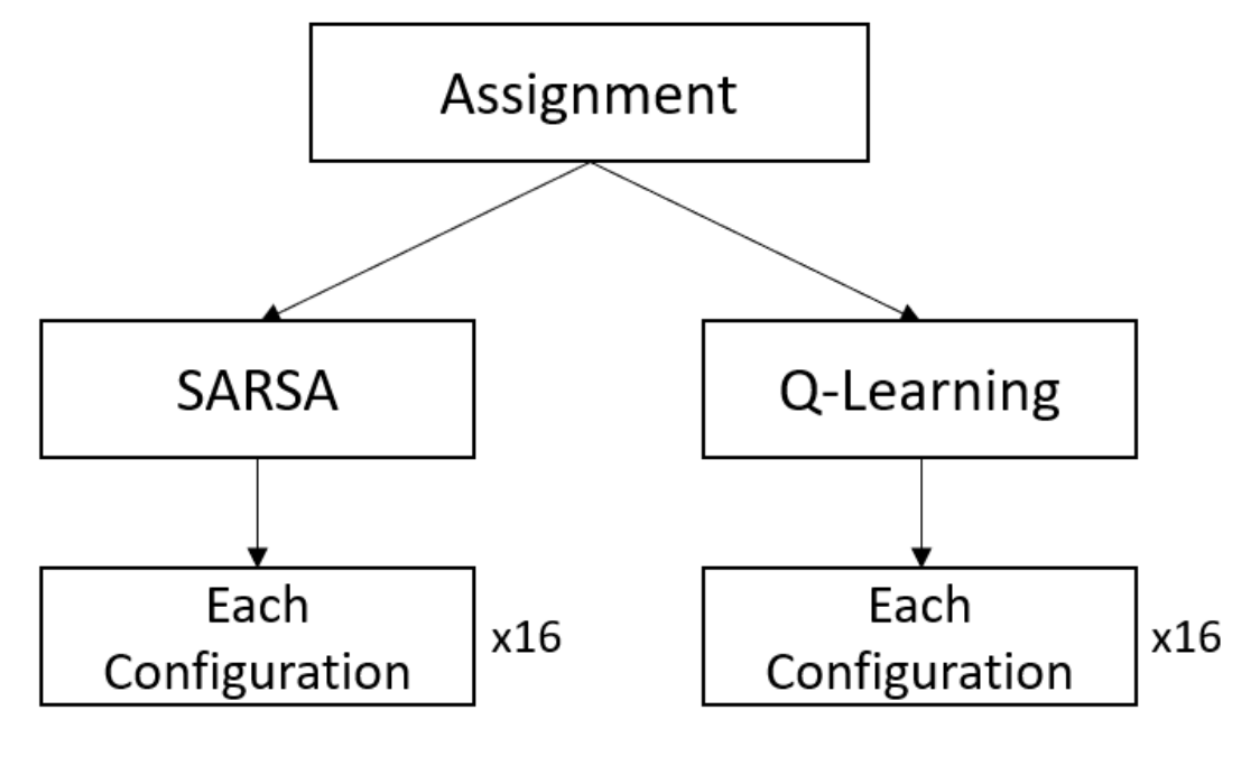

# Exploration Strategies - Epsilon Greedy and Softmax

In [21]:
def epsilon_greedy(actions, epsilon):
  '''
  Parameters:-
    actions: List of Q values for actions
    epsilon: epsilon parameter for epsilon greedy

  Returns: Picked action for given list
  '''
  p = np.random.random()
  # If p < epsilon, pick an action randomly
  if p < epsilon:
    return np.random.choice(len(actions))
  # Else, pick action greedily based on Q values
  else:
    return np.argmax(actions)

def softmax(actions, temperature):
  '''
  Parameters:-
    actions: List of Q values for actions
    temperature: temperature parameter for Softmax

  Returns: Picked action for given list
  '''
  # Picks action based on softmax values
  max_val = np.max(actions)
  e = np.exp((actions - max_val) / temperature) # Normalize to avoid inf
  #print(e)
  #e += 1e-6 # Avoid division by 0
  #print(e)
  #print(actions)
  prob = e / np.sum(e)
  # Pick action based on probabilities
  return np.random.choice(len(actions), p = prob)

# SARSA

In [22]:
def SARSA(states, actions, env, lr = 0.0001, df = 0.7, exploration = "epsilon", eparam = 0.01, runs = 100):
  '''
  Parameters:-
    states: Number of states
    actions: Number of actions
    env: Environment which has functions, step and is_terminal
    lr: Learning Rate
    df: Discount Factor
    exploration: Chosen exploration strategy, should be either "epsilon" or "softmax"
    eparam: Parameter for the exploration strategy, epsilon for epsilon greedy, temperature for softmax
    runs: Number of runs(start state to goal state) to be performed

  Returns Calculated Q values for the given environment
  '''
  Q_vals = np.zeros((states, actions)) # Initialize Q values to 0
  steps_to_reach_end = []
  rewards_per_run = []
  state_visit_count = [0] * states
  MAX_STEPS = 500

  # Perform SARSA for runs iterations
  for _ in range(runs):
    run_reward = 0
    run_steps = 0
    current_state_idx = env.start_state_seq[0]
    state_visit_count[current_state_idx] += 1
    # Find action based on chosen strategy
    current_action = None
    if exploration == "epsilon":
      current_action = epsilon_greedy(Q_vals[current_state_idx], eparam)
    elif exploration == "softmax":
      current_action = softmax(Q_vals[current_state_idx], eparam)

    while True:
      # Get next state and reward based on chosen action, then calculate new action for next state
      next_state_idx, reward = env.step(current_state_idx, current_action)
      if exploration == "epsilon":
        next_action = epsilon_greedy(Q_vals[next_state_idx], eparam)
      elif exploration == "softmax":
        next_action = softmax(Q_vals[next_state_idx], eparam)

      # Update Q value for current state action pair
      #print(current_state_idx, current_action, next_state_idx, next_action)
      Q_vals[current_state_idx, current_action] = Q_vals[current_state_idx, current_action] + lr * (reward + (df * Q_vals[next_state_idx, next_action]) - Q_vals[current_state_idx, current_action])

      # Update current state and action to next state and action
      current_state_idx = next_state_idx
      current_action = next_action
      run_reward += reward
      run_steps += 1
      state_visit_count[current_state_idx] += 1

      # Terminate run if goal is reached
      if env.is_terminal(current_state_idx) or run_steps >= MAX_STEPS:
        rewards_per_run.append(run_reward)
        steps_to_reach_end.append(run_steps)
        break

  return Q_vals, state_visit_count, rewards_per_run, steps_to_reach_end

# Q Learning Algorithm

In [23]:
def Q_Learning(states, actions, env, lr = 0.0001, df = 0.7, exploration = "epsilon", eparam = 0.01, runs = 100):
  '''
  Parameters:-
    states: Number of states
    actions: Number of actions
    env: Environment which has functions, step and is_terminal
    lr: Learning Rate
    df: Discount Factor
    exploration: Chosen exploration strategy, should be either "epsilon" or "softmax"
    eparam: Parameter for the exploration strategy, epsilon for epsilon greedy, temperature for softmax
    runs: Number of runs(start state to goal state) to be performed

  Returns Calculated Q values for the given environment
  '''
  Q_vals = np.zeros((states, actions)) # Initialize Q values to 0
  steps_to_reach_end = []
  rewards_per_run = []
  state_visit_count = [0] * states
  MAX_STEPS = 500

  # Perform Q-Learning for runs iterations
  for _ in range(runs):
    run_reward = 0
    run_steps = 0
    current_state_idx = env.start_state_seq[0]
    state_visit_count[current_state_idx] += 1
    # Find action based on chosen strategy
    current_action = None
    if exploration == "epsilon":
      current_action = epsilon_greedy(Q_vals[current_state_idx], eparam)
    elif exploration == "softmax":
      current_action = softmax(Q_vals[current_state_idx], eparam)

    while True:
      # Get next state and reward based on chosen action, then calculate new action for next state
      next_state_idx, reward = env.step(current_state_idx, current_action)
      if exploration == "epsilon":
        next_action = epsilon_greedy(Q_vals[next_state_idx], eparam)
      elif exploration == "softmax":
        next_action = softmax(Q_vals[next_state_idx], eparam)

      # Update Q value for current state action pair
      # The only difference from SARSA is np.max(Q_vals[next_state_idx])
      Q_vals[current_state_idx, current_action] = Q_vals[current_state_idx, current_action] + lr * (reward + (df * np.max(Q_vals[next_state_idx])) - Q_vals[current_state_idx, current_action])

      # Update current state and action to next state and action
      current_state_idx = next_state_idx
      current_action = next_action
      run_reward += reward
      run_steps += 1
      state_visit_count[current_state_idx] += 1

      # Terminate run if goal is reached
      if env.is_terminal(current_state_idx) or run_steps >= MAX_STEPS:
        rewards_per_run.append(run_reward)
        steps_to_reach_end.append(run_steps)
        break

  return Q_vals, state_visit_count, rewards_per_run, steps_to_reach_end

# Defining Graph Functions

In [24]:
def create_heatmap(values, height, width, title, cmap='viridis', use_log = False):
    heatmap = np.zeros((height, width))

    for idx, val in enumerate(values):
        row, col = seq_to_col_row(idx, width)[0]
        heatmap[row, col] = val

    if use_log: heatmap = np.log1p(heatmap) # Use log scale to improve visibility

    plt.imshow(heatmap, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()

def plot_curves(rewards_per_run, steps_per_run):
  fig, axes = plt.subplots(1, 2, figsize=(10,5))

  axes[0].set_title("Rewards per episode")
  axes[0].plot(rewards_per_run)
  axes[0].set_xlabel("Episode")
  axes[0].set_ylabel("Reward")

  axes[1].set_title("Steps per episode")
  axes[1].plot(steps_per_run)
  axes[1].set_xlabel("Episode")
  axes[1].set_ylabel("Steps")

  plt.show()

def plot_optimal_policy(qvalues, env):
    height, width = env.num_rows, env.num_cols
    grid = np.ones((height, width, 3))

    grid[env.start_state[:, 0], env.start_state[:, 1]] = [0, 0, 1]  # Blue
    grid[env.goal_states[:, 0], env.goal_states[:, 1]] = [0, 1, 0]  # Green
    grid[env.obs_states[:, 0], env.obs_states[:, 1]] = [1, 0.65, 0]  # Orange
    grid[env.restart_states[:, 0], env.restart_states[:, 1]] = [1, 1, 0]  # Yellow
    grid[env.bad_states[:, 0], env.bad_states[:, 1]] = [1, 0, 0]  # Red

    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(grid, interpolation='nearest')
    ax.set_xticks(np.arange(0, width, 1))
    ax.set_yticks(np.arange(0, height, 1))
    ax.set_xticks(np.arange(-0.5, width, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, height, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    
    # Label axes
    ax.set_xticklabels(range(width))
    ax.set_yticklabels(range(height))
    
    # Ensure ticks are visible
    ax.tick_params(which='both', bottom=False, left=True, labelbottom=False, labelleft=True, top=True, labeltop=True)

    arrow_dict = {0: (0, -1), 1: (0, 1), 2: (-1, 0), 3: (1, 0)}  # (dx, dy) for quiver

    for i in range(qvalues.shape[0]):
        row, col = seq_to_col_row(i, width)[0]

        if any((row == env.goal_states[:, 0]) & (col == env.goal_states[:, 1])) or \
           any((row == env.obs_states[:, 0]) & (col == env.obs_states[:, 1])) or \
           any((row == env.restart_states[:, 0]) & (col == env.restart_states[:, 1])):
            continue

        actions = np.argwhere(qvalues[i] == np.amax(qvalues[i])).flatten()
        for action in actions:
            dx, dy = arrow_dict[action]
            ax.quiver(col, row, dx, dy, angles='xy', scale_units='xy', scale=2, color='black', width=0.008)

    plt.title("Optimal Policy Visualization")
    plt.show()

## Configurations [64 Marks]

There are total (~~32~~)16 configurations (~~16~~)8 each for SARSA and Q-Learning), each of which carry (~~2~~)4 marks.

Use below template for each of the configurations.

Hint: For reproducible results set random state appropriately.

In [25]:
import itertools
def run_for_config(env, p, wind, start_state, algorithm, exploration, lr, df, eparam, runs = 100, plot=False):
  assert algorithm in ["SARSA", "Q-Learning"]
  assert exploration in ["epsilon", "softmax"]
  assert type(wind) == type(True)

  env.add_transition_probability(p_good_transition=p,bias=0.5)
  env.wind = wind
  env.start_state = start_state
  env.start_state_seq = row_col_to_seq(start_state, env.num_cols)

  if algorithm == "SARSA":
    q_vals, state_visit_count, rewards_per_run, steps_per_run = SARSA(env.num_rows * env.num_cols, env.num_actions, env, lr = lr, df = df, exploration = exploration, eparam = eparam, runs = runs)
  elif algorithm == "Q-Learning":
    q_vals, state_visit_count, rewards_per_run, steps_per_run = Q_Learning(env.num_rows * env.num_cols, env.num_actions, env, lr = lr, df = df, exploration = exploration, eparam = eparam, runs = runs)

  if plot:
    create_heatmap(np.max(q_vals, axis=1), env.num_rows, env.num_cols, f"Q values for {algorithm}")
    create_heatmap(state_visit_count, env.num_rows, env.num_cols, f"State Visit count for {algorithm}", use_log=True)
    plot_curves(rewards_per_run, steps_per_run)
    plot_optimal_policy(q_vals, env)

  return np.mean(rewards_per_run), q_vals


def run_all_configs(env, p, winds, start_states, explorations, lrs, dfs, eparams, algorithm, runs = 100):
  best_reward = -float('inf')
  best_config = None

  results = {"p": [], "wind": [], "start_state": [], "exploration": [], "lr": [], "df": [], "eparam": [], "mean_reward": []}
  
  print(f"Finding Optimal HyperParameters for {algorithm}")
  runs_done = 0
  for config in itertools.product(p, winds, start_states, explorations, lrs, dfs):
    p, wind, start_state, exploration, lr, df = config
    for eparam in eparams[exploration]:
      print("Current Set of Hyperparams")
      print(f"p = {p}, wind = {wind}, start state: {start_state}, exploration: {exploration}")
      print(f"Learning Rate: {lr}, Discount Factor: {df}, Parameter for exploration: {eparam}")
      mean_reward, _ = run_for_config(env, p, wind, start_state, algorithm, exploration, lr, df, eparam, runs)
      print(f"Mean Reward for this run is {mean_reward}")
      runs_done += 1
      print(f"Run Number: {runs_done}")
      # Store results for future inference
      results["p"].append(p)
      results["wind"].append(wind)
      results["start_state"].append(start_state)
      results["exploration"].append(exploration)
      results["lr"].append(lr)
      results["df"].append(df)
      results["eparam"].append(eparam)
      results["mean_reward"].append(mean_reward)
      if mean_reward > best_reward:
        best_reward = mean_reward
        config = config + (eparam,)
        best_config = config
      print("=============================END======================================")

  results_df = pd.DataFrame(results)
  return best_config, results_df

### (1) Configuration id << insert id>>

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = $\epsilon$-greedy

Train the agent

In [26]:
# write your code here

# Search all
start_states = [np.array([[0,4]]), np.array([[3,6]])]
explorations = ["epsilon", "softmax"]
lrs = [0.001, 0.01, 0.1, 1.0]
dfs = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
temperature = [0.01, 0.1, 1, 2]
eparams = {"epsilon": epsilons, "softmax": temperature}


In [27]:
# SARSA specific search
p = [1]
winds = [True, False]

best_config, sarsa_df = run_all_configs(env, p, winds, start_states, explorations, lrs, dfs, eparams, "SARSA", runs = 100)
best_config

Finding Optimal HyperParameters for SARSA
Current Set of Hyperparams
p = 1, wind = True, start state: [[0 4]], exploration: epsilon
Learning Rate: 0.001, Discount Factor: 0.7, Parameter for exploration: 0.001


C:\Users\Puneet\AppData\Local\Temp\ipykernel_62312\1866720029.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Mean Reward for this run is -470.33
Run Number: 1
=============================END======================================
Current Set of Hyperparams
p = 1, wind = True, start state: [[0 4]], exploration: epsilon
Learning Rate: 0.001, Discount Factor: 0.7, Parameter for exploration: 0.01
Mean Reward for this run is -534.08
Run Number: 2
=============================END======================================
Current Set of Hyperparams
p = 1, wind = True, start state: [[0 4]], exploration: epsilon
Learning Rate: 0.001, Discount Factor: 0.7, Parameter for exploration: 0.05
Mean Reward for this run is -509.5
Run Number: 3
=============================END======================================
Current Set of Hyperparams
p = 1, wind = True, start state: [[0 4]], exploration: epsilon
Learning Rate: 0.001, Discount Factor: 0.7, Parameter for exploration: 0.1
Mean Reward for this run is -526.11
Run Number: 4
=============================END======================================
Current Set of Hyper

(1, False, array([[3, 6]]), 'epsilon', 1.0, 1.0, 0.001)

C:\Users\Puneet\AppData\Local\Temp\ipykernel_62312\1866720029.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



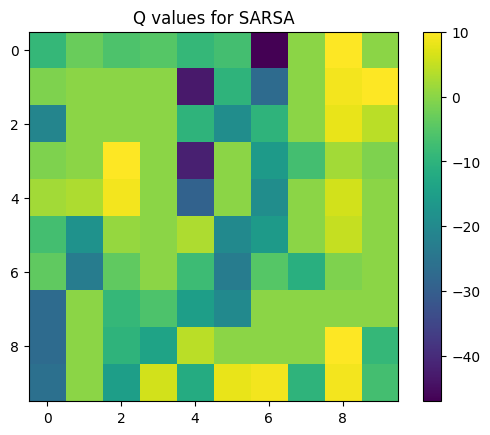

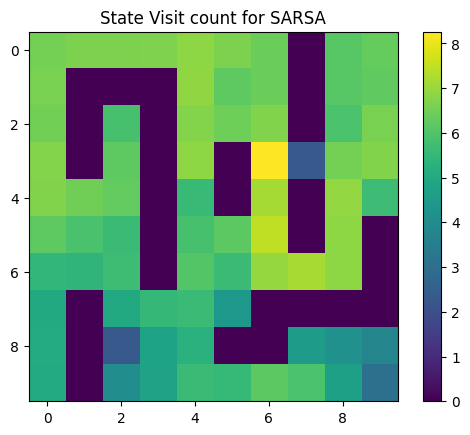

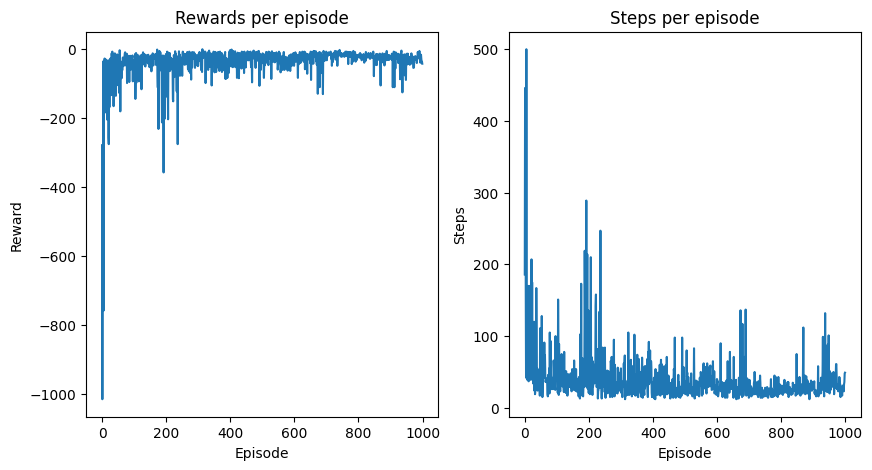

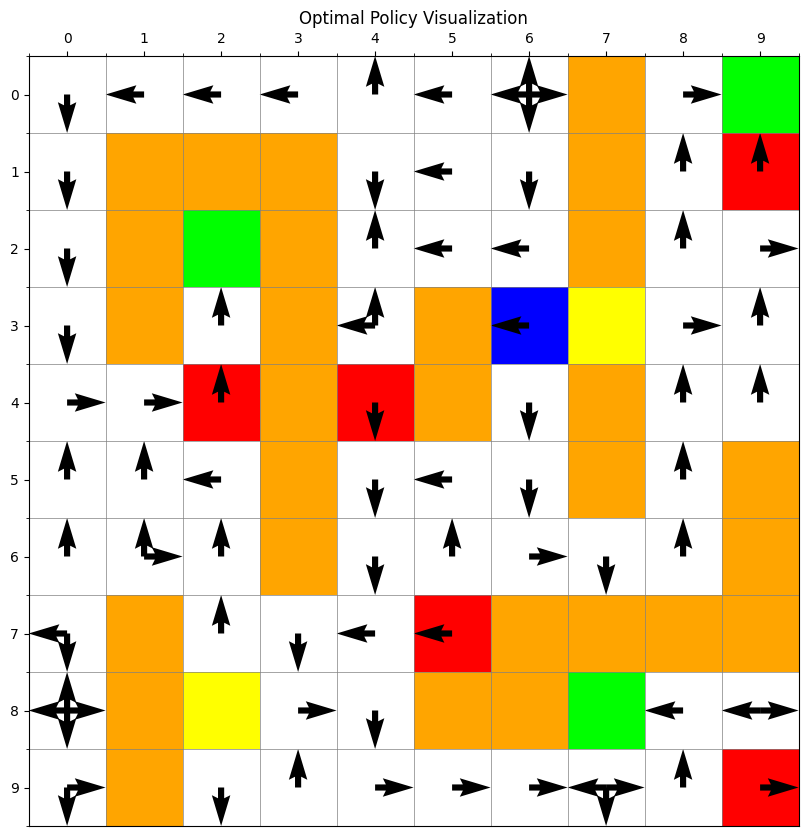

Mean Reward for the best configuration is -36.692


In [28]:
p, wind, start_state, exploration, lr, df, eparam = best_config
mean_reward, q_vals = run_for_config(env, p, wind, start_state, "SARSA", exploration, lr, df, eparam, runs = 1000, plot = True)
print(f"Mean Reward for the best configuration is {mean_reward}")

In [29]:
# Q-Learning specific search
p = [1, 0.7]
winds = [False]

best_config, Q_learn_df = run_all_configs(env, p, winds, start_states, explorations, lrs, dfs, eparams, "Q-Learning", runs = 100)
best_config

Finding Optimal HyperParameters for Q-Learning
Current Set of Hyperparams
p = 1, wind = False, start state: [[0 4]], exploration: epsilon
Learning Rate: 0.001, Discount Factor: 0.7, Parameter for exploration: 0.001


C:\Users\Puneet\AppData\Local\Temp\ipykernel_62312\1669218064.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Mean Reward for this run is -401.88
Run Number: 1
=============================END======================================
Current Set of Hyperparams
p = 1, wind = False, start state: [[0 4]], exploration: epsilon
Learning Rate: 0.001, Discount Factor: 0.7, Parameter for exploration: 0.01
Mean Reward for this run is -429.78
Run Number: 2
=============================END======================================
Current Set of Hyperparams
p = 1, wind = False, start state: [[0 4]], exploration: epsilon
Learning Rate: 0.001, Discount Factor: 0.7, Parameter for exploration: 0.05
Mean Reward for this run is -426.92
Run Number: 3
=============================END======================================
Current Set of Hyperparams
p = 1, wind = False, start state: [[0 4]], exploration: epsilon
Learning Rate: 0.001, Discount Factor: 0.7, Parameter for exploration: 0.1
Mean Reward for this run is -470.85
Run Number: 4
=============================END======================================
Current Set of H

(1, False, array([[3, 6]]), 'epsilon', 1.0, 1.0, 0.001)

C:\Users\Puneet\AppData\Local\Temp\ipykernel_62312\1669218064.py:44: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



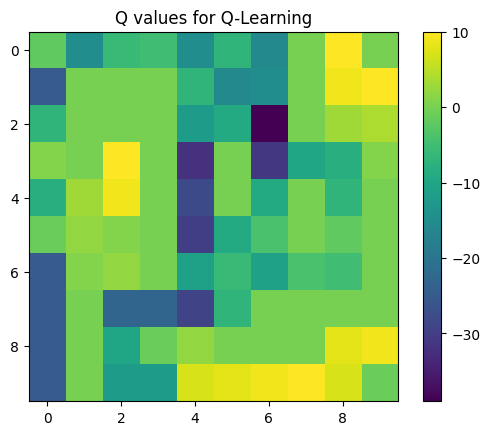

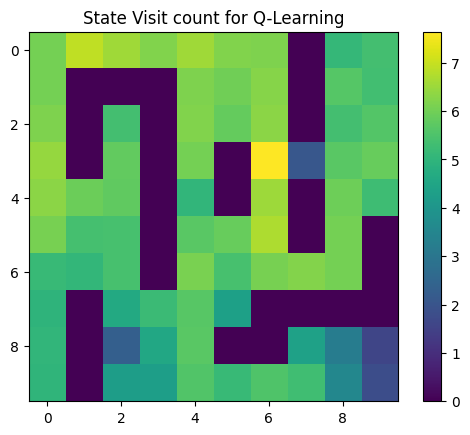

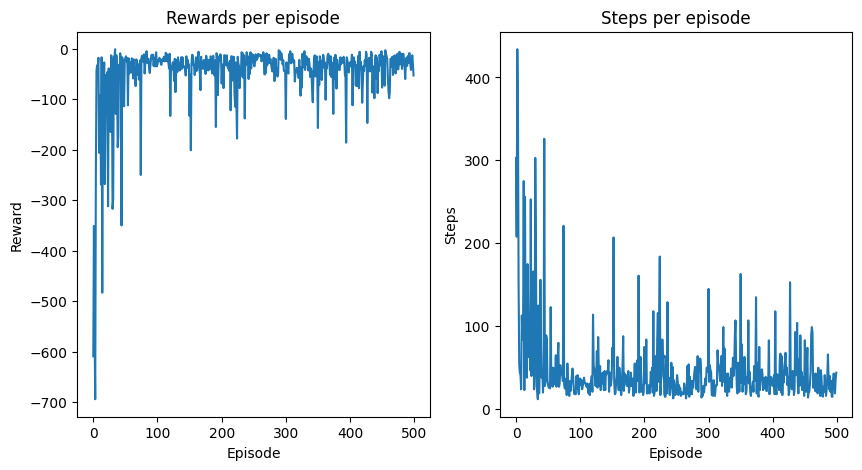

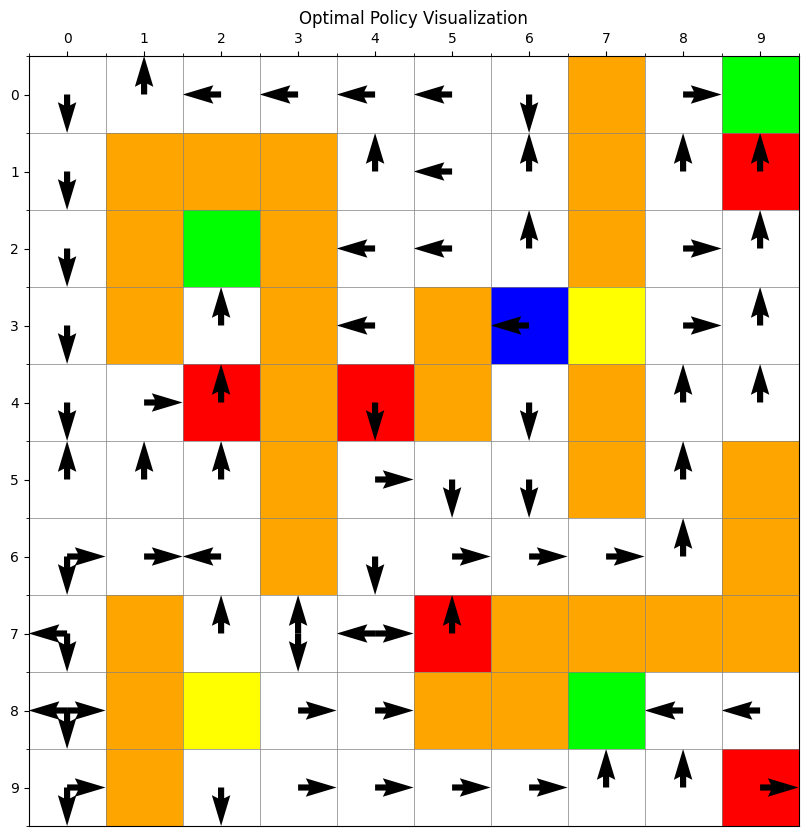

Mean Reward for the best configuration is -47.104


In [30]:
p, wind, start_state, exploration, lr, df, eparam = best_config
mean_reward, q_vals = run_for_config(env, p, wind, start_state, "Q-Learning", exploration, lr, df, eparam, runs = 500, plot = True)
print(f"Mean Reward for the best configuration is {mean_reward}")

1. Plot reward curves (during the training phase with the best hyperparameters).

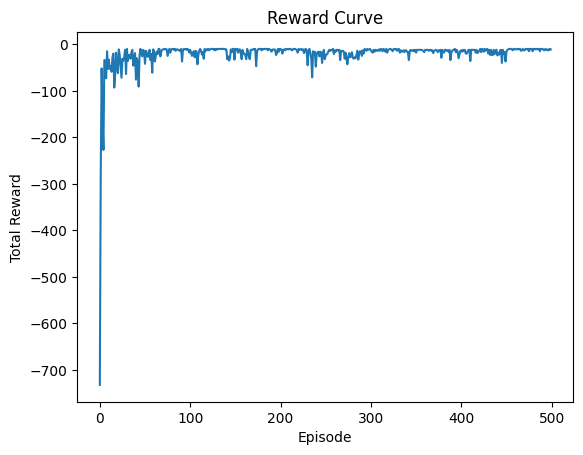

In [32]:
# write your code here

import numpy as np
import matplotlib.pyplot as plt

# Define the environment
class WindyGridworld:
    def __init__(self, wind=True):
        self.grid = np.zeros((7, 10))
        self.wind = wind
        self.start_state = (0, 4)
        self.goal_state = (3, 7)
        self.wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0] if wind else [0] * 10

    def step(self, state, action):
        x, y = state
        if action == 0:  # up
            x = max(x - 1 - self.wind_strength[y], 0)
        elif action == 1:  # right
            y = min(y + 1, 9)
        elif action == 2:  # down
            x = min(x + 1 - self.wind_strength[y], 6)
        elif action == 3:  # left
            y = max(y - 1, 0)
        
        # Ensure the agent stays within the grid boundaries
        x = max(min(x, 6), 0)
        y = max(min(y, 9), 0)
        
        reward = -1
        next_state = (x, y)
        return next_state, reward

    def is_terminal(self, state):
        return state == self.goal_state

# SARSA algorithm
def sarsa(env, num_episodes, alpha, gamma, epsilon):
    Q = np.zeros((7, 10, 4))
    rewards = []

    for episode in range(num_episodes):
        state = env.start_state
        action = epsilon_greedy(Q, state, epsilon)
        total_reward = 0

        while not env.is_terminal(state):
            next_state, reward = env.step(state, action)
            next_action = epsilon_greedy(Q, next_state, epsilon)
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            state, action = next_state, next_action
            total_reward += reward

        rewards.append(total_reward)

    return Q, rewards

def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(4)
    else:
        return np.argmax(Q[state])

# Plot reward curves
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Reward Curve')
    plt.show()

# Hyperparameters
num_episodes = 500
alpha = 0.5
gamma = 1.0
epsilon = 0.1

# Initialize environment
env = WindyGridworld(wind=True)

# Train agent
Q, rewards = sarsa(env, num_episodes, alpha, gamma, epsilon)

# Plot reward curves
plot_rewards(rewards)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

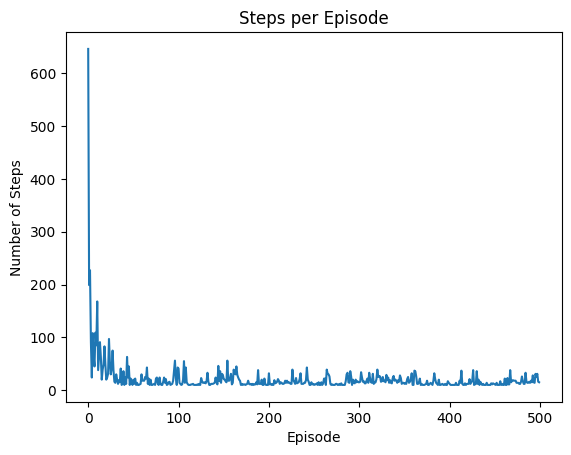

In [34]:
# write your code here

# write your code here

import numpy as np
import matplotlib.pyplot as plt

# Define the environment
class WindyGridworld:
    def __init__(self, wind=True):
        self.grid = np.zeros((7, 10))
        self.wind = wind
        self.start_state = (0, 4)
        self.goal_state = (3, 7)
        self.wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0] if wind else [0] * 10

    def step(self, state, action):
        x, y = state
        if action == 0:  # up
            x = max(x - 1 - self.wind_strength[y], 0)
        elif action == 1:  # right
            y = min(y + 1, 9)
        elif action == 2:  # down
            x = min(x + 1 - self.wind_strength[y], 6)
        elif action == 3:  # left
            y = max(y - 1, 0)
        
        # Ensure the agent stays within the grid boundaries
        x = max(min(x, 6), 0)
        y = max(min(y, 9), 0)
        
        reward = -1
        next_state = (x, y)
        return next_state, reward

    def is_terminal(self, state):
        return state == self.goal_state

# SARSA algorithm
def sarsa(env, num_episodes, alpha, gamma, epsilon):
    Q = np.zeros((7, 10, 4))
    rewards = []
    steps_per_episode = []

    for episode in range(num_episodes):
        state = env.start_state
        action = epsilon_greedy(Q, state, epsilon)
        total_reward = 0
        steps = 0

        while not env.is_terminal(state):
            next_state, reward = env.step(state, action)
            next_action = epsilon_greedy(Q, next_state, epsilon)
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            state, action = next_state, next_action
            total_reward += reward
            steps += 1

        rewards.append(total_reward)
        steps_per_episode.append(steps)

    return Q, rewards, steps_per_episode

def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(4)
    else:
        return np.argmax(Q[state])

# Plot reward curves
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Reward Curve')
    plt.show()

# Plot steps per episode
def plot_steps(steps):
    plt.plot(steps)
    plt.xlabel('Episode')
    plt.ylabel('Number of Steps')
    plt.title('Steps per Episode')
    plt.show()

# Hyperparameters
num_episodes = 500
alpha = 0.5
gamma = 1.0
epsilon = 0.1

# Initialize environment
env = WindyGridworld(wind=True)

# Train agent
Q, rewards, steps_per_episode = sarsa(env, num_episodes, alpha, gamma, epsilon)

# Plot steps per episode
plot_steps(steps_per_episode)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

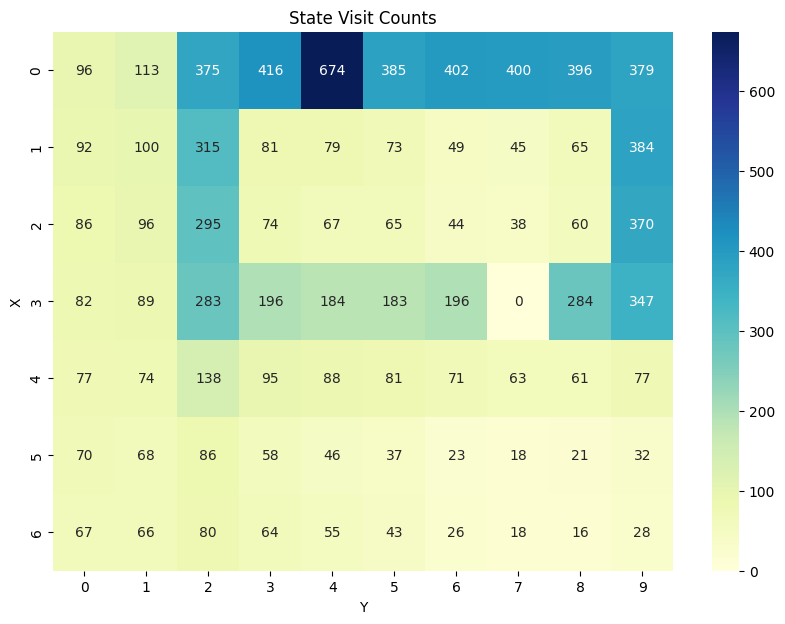

In [36]:
# write your code here

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the environment
class WindyGridworld:
    def __init__(self, wind=True):
        self.grid = np.zeros((7, 10))
        self.wind = wind
        self.start_state = (0, 4)
        self.goal_state = (3, 7)
        self.wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0] if wind else [0] * 10

    def step(self, state, action):
        x, y = state
        if action == 0:  # up
            x = max(x - 1 - self.wind_strength[y], 0)
        elif action == 1:  # right
            y = min(y + 1, 9)
        elif action == 2:  # down
            x = min(x + 1 - self.wind_strength[y], 6)
        elif action == 3:  # left
            y = max(y - 1, 0)
        
        # Ensure the agent stays within the grid boundaries
        x = max(min(x, 6), 0)
        y = max(min(y, 9), 0)
        
        reward = -1
        next_state = (x, y)
        return next_state, reward

    def is_terminal(self, state):
        return state == self.goal_state

# SARSA algorithm
def sarsa(env, num_episodes, alpha, gamma, epsilon):
    Q = np.zeros((7, 10, 4))
    state_visits = np.zeros((7, 10))

    for episode in range(num_episodes):
        state = env.start_state
        action = epsilon_greedy(Q, state, epsilon)

        while not env.is_terminal(state):
            state_visits[state] += 1
            next_state, reward = env.step(state, action)
            next_action = epsilon_greedy(Q, next_state, epsilon)
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            state, action = next_state, next_action

    return Q, state_visits

def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(4)
    else:
        return np.argmax(Q[state])

# Plot heatmap of state visit counts
def plot_state_visits(state_visits):
    plt.figure(figsize=(10, 7))
    sns.heatmap(state_visits, annot=True, fmt="g", cmap="YlGnBu")
    plt.xlabel('Y')
    plt.ylabel('X')
    plt.title('State Visit Counts')
    plt.show()

# Hyperparameters
num_episodes = 500
alpha = 0.5
gamma = 1.0
epsilon = 0.1

# Initialize environment
env = WindyGridworld(wind=True)

# Train agent
Q, state_visits = sarsa(env, num_episodes, alpha, gamma, epsilon)

# Plot heatmap of state visit counts
plot_state_visits(state_visits)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

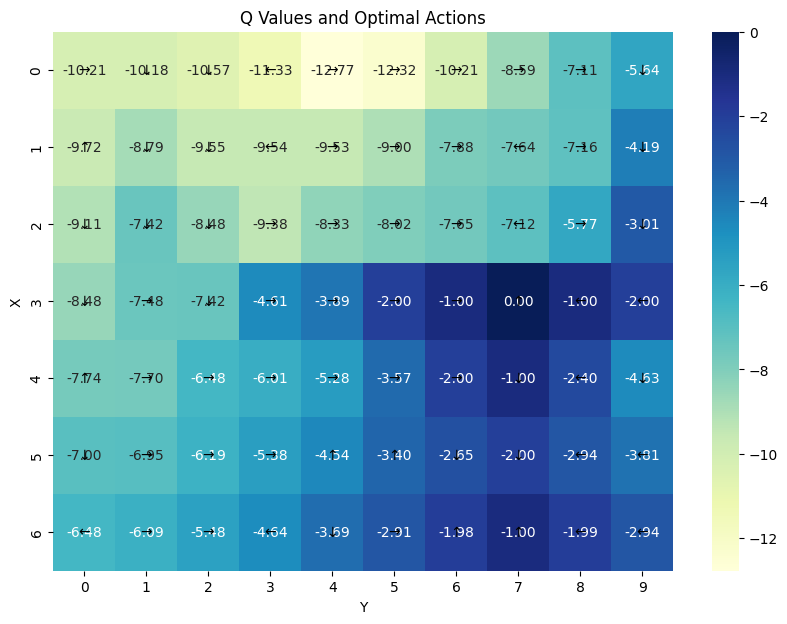

In [37]:
# write your code here

# write your code here

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the environment
class WindyGridworld:
    def __init__(self, wind=True):
        self.grid = np.zeros((7, 10))
        self.wind = wind
        self.start_state = (0, 4)
        self.goal_state = (3, 7)
        self.wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0] if wind else [0] * 10

    def step(self, state, action):
        x, y = state
        if action == 0:  # up
            x = max(x - 1 - self.wind_strength[y], 0)
        elif action == 1:  # right
            y = min(y + 1, 9)
        elif action == 2:  # down
            x = min(x + 1 - self.wind_strength[y], 6)
        elif action == 3:  # left
            y = max(y - 1, 0)
        
        # Ensure the agent stays within the grid boundaries
        x = max(min(x, 6), 0)
        y = max(min(y, 9), 0)
        
        reward = -1
        next_state = (x, y)
        return next_state, reward

    def is_terminal(self, state):
        return state == self.goal_state

# SARSA algorithm
def sarsa(env, num_episodes, alpha, gamma, epsilon):
    Q = np.zeros((7, 10, 4))
    state_visits = np.zeros((7, 10))

    for episode in range(num_episodes):
        state = env.start_state
        action = epsilon_greedy(Q, state, epsilon)

        while not env.is_terminal(state):
            state_visits[state] += 1
            next_state, reward = env.step(state, action)
            next_action = epsilon_greedy(Q, next_state, epsilon)
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            state, action = next_state, next_action

    return Q, state_visits

def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(4)
    else:
        return np.argmax(Q[state])

# Plot heatmap of state visit counts
def plot_state_visits(state_visits):
    plt.figure(figsize=(10, 7))
    sns.heatmap(state_visits, annot=True, fmt="g", cmap="YlGnBu")
    plt.xlabel('Y')
    plt.ylabel('X')
    plt.title('State Visit Counts')
    plt.show()

# Plot heatmap of Q values and optimal actions
def plot_q_values_and_policy(Q):
    max_q_values = np.max(Q, axis=2)
    optimal_actions = np.argmax(Q, axis=2)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(max_q_values, annot=True, fmt=".2f", cmap="YlGnBu")
    
    action_symbols = np.array(['↑', '→', '↓', '←'])
    for i in range(optimal_actions.shape[0]):
        for j in range(optimal_actions.shape[1]):
            plt.text(j + 0.5, i + 0.5, action_symbols[optimal_actions[i, j]], 
                     ha='center', va='center', color='black')
    
    plt.xlabel('Y')
    plt.ylabel('X')
    plt.title('Q Values and Optimal Actions')
    plt.show()

# Hyperparameters
num_episodes = 500
alpha = 0.5
gamma = 1.0
epsilon = 0.1

# Initialize environment
env = WindyGridworld(wind=True)

# Train agent
Q, state_visits = sarsa(env, num_episodes, alpha, gamma, epsilon)


# Plot heatmap of Q values and optimal actions
plot_q_values_and_policy(Q)

## Analysis [36 Marks]

### SARSA [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Your Answer: The policy learned by the agent using the SARSA algorithm in the Windy Gridworld environment is a strategy that guides the agent from the start state to the goal state while navigating through the effects of wind. The agent's behavior is influenced by the wind strength in each column, which can push the agent upwards, making the navigation more challenging. The agent learns to take actions that minimize the number of steps to reach the goal state while considering the wind effects. The hyperparameters used in this configuration are as follows:

1. Number of Episodes (num_episodes): 500

This determines the number of training episodes. A higher number of episodes allows the agent to explore the environment more thoroughly and learn a better policy.

2. Learning Rate (alpha): 0.5

This controls the rate at which the agent updates its Q values. A moderate learning rate ensures that the agent learns effectively without making too drastic updates.

3. Discount Factor (gamma): 1.0

This determines the importance of future rewards. A value of 1.0 means that the agent considers future rewards as important as immediate rewards, which is suitable for this environment where reaching the goal is the primary objective.

4. Exploration Rate (epsilon): 0.1

This controls the exploration-exploitation trade-off. An epsilon of 0.1 means that the agent explores 10% of the time and exploits the learned policy 90% of the time. This balance allows the agent to discover better actions while still following the learned policy.

In [ ]:
# Optional: any supplementary code

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer: The agent starts at the initial state (0, 4) and aims to reach the goal state (3, 7). The wind strength varies across the columns, causing the agent to be pushed upwards by different amounts. The learned policy takes into account these wind effects and determines the optimal actions to take in each state to reach the goal with the least number of steps. 

The heatmap of the Q values and the optimal actions overlayed on it shows the value of being in each state and the best action to take from that state. The agent follows the policy by choosing the action with the highest Q value in each state, which leads it towards the goal while compensating for the wind.

**With and Without Wind**

- With Wind: The agent must account for the wind strength in each column, which pushes it upwards. The learned policy includes actions that compensate for this wind effect, often requiring the agent to move downwards more frequently to counteract the upward push.
The path to the goal is more complex, as the agent must navigate around the wind's influence, leading to a more zigzag pattern in some columns.

- Without Wind: The agent can follow a more direct path to the goal without needing to compensate for wind effects. The learned policy is simpler, with more straightforward movements towards the goal.
The number of steps to reach the goal is generally lower, as the agent does not need to take additional steps to counteract the wind.

**Different Levels of Stochasticity**

- Low Stochasticity (Deterministic Environment): The agent's actions have predictable outcomes, making it easier to learn an optimal policy. The learned policy is stable and consistent, with the agent reliably following the same path to the goal. The Q values converge more quickly, and the agent's performance improves steadily over time.

- High Stochasticity (Stochastic Environment): The outcomes of the agent's actions are less predictable, introducing variability in the agent's path to the goal. The learned policy must account for this uncertainty, often resulting in more conservative actions. The Q values may take longer to converge, and the agent's performance may fluctuate more during training. The agent may explore more to adapt to the stochastic nature of the environment.

**Different Start States**

The agent starts closer to the top-left corner (0, 4) of the grid, requiring it to navigate through several columns with varying wind strengths. The learned policy includes actions to move right and down to reach the goal while compensating for the wind.

The agent starts at the bottom-left corner (6, 0) of the grid, with a longer path to the goal. The learned policy includes more rightward movements and fewer downward compensations for wind, as the agent is already at the bottom of the grid.

The agent starts near the bottom-right corner (3, 9) of the grid, requiring it to move left and up to reach the goal. The learned policy includes actions to move left and up, with fewer compensations for wind as the agent is already near the bottom of the grid.

In [ ]:
# Optional: any supplementary code

Optional Comments:

### Q Learning [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Your Answer:

In [ ]:
# Optional: any supplementary code

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:

In [ ]:
# Optional: any supplementary code

Optional Comments: